# Проект LTV/CAC: Снижение затрат с помощью RFM-анализа

LTV чемпионов в 9.34 раза выше, чем у остальных, что позволяет безопасно сократить CAC

In [53]:
import pandas as pd
import datetime as dt
import seaborn as sns

import json
from google.colab import userdata

#Скачивание и распаковка датасета (Online Retail, KAGGLE)

kaggle_username = "userdata.get('KAGGLE_USER')"
kaggle_key = "userdata.get('KAGGLE_API')"
token = {"username": kaggle_username, "key": kaggle_key}

!mkdir -p ~/.kaggle

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

!chmod 600 ~/.kaggle/kaggle.json

print("\nКлюч установлен\n")


!kaggle datasets download -d vijayuv/onlineretail

!unzip -o onlineretail.zip

print("\nФайл распакован.\n")


Ключ установлен

Dataset URL: https://www.kaggle.com/datasets/vijayuv/onlineretail
License(s): CC0-1.0
onlineretail.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  onlineretail.zip
  inflating: OnlineRetail.csv        

Файл распакован.



In [46]:
# Чтение файла

filename = 'OnlineRetail.csv'
df = pd.read_csv(filename, encoding='ISO-8859-1')

print("Датафрейм готов")

In [28]:
#Просмотр общей структуры

print(df.head())
print(df.tail())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  
       InvoiceNo StockCode                      Description  Quantity  \
541904    581587     22613      PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899     CHILDREN'S APRON DOLLY GIRL         

In [29]:
#Просмотр масштаба

print(df.shape)

(541909, 8)


In [30]:
#Просмотр типов данных, совпадений с ожидаемыми

print(df.dtypes)

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object


In [31]:
#Выявление пропусков

df.isna().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [47]:
#Подготовка к анализу

##Замена типа данных в колонке InvoiceDate на datetime

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

##Удаление строк с отсутствующим CustomerID

df = df.dropna(subset = ['CustomerID'])

##Замена типа данных в колонке CustomerID на int

df['CustomerID'] = df['CustomerID'].astype('int32')

##Фильтрация строк с положительными Quantity и UnitPrice

df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

In [48]:
#RFM-анализ

##Получение полной суммы каждой транзакции в колонке Sales

df['Sales'] = df['Quantity'] * df['UnitPrice']

##Получение метрик F, M - кол-во транзакций и общая сумма для каждого клиента

rfm_df = df.groupby('CustomerID').agg(
  Monetary=('Sales', 'sum'),
  Frequency=('InvoiceNo', 'nunique')
)

##Получение метрики R - давность последней транзакции в днях

date_of_analysis = df['InvoiceDate'].max() + dt.timedelta(days=1)

rfm_df['Recency'] = (date_of_analysis - df.groupby('CustomerID')['InvoiceDate'].max()).dt.days

##Вычисление баллов по метрикам

####Метрике R баллы присваиваются в обратном порядке, т.к. большее значение дает меньший результат

####Макс. кол-во баллов(4) для F определено с помощью атр. "retbins=True"

rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], q=5, labels=range(5, 0, -1))
rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'], q=5, labels=range(1, 5), duplicates='drop')
rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'], q=5, labels=range(1, 6))

##Объединение баллов в сегменты

R_str = rfm_df['R_Score'].astype('str')
F_str = rfm_df['F_Score'].astype('str')
M_str = rfm_df['M_Score'].astype('str')

rfm_df['RFM_Segment'] = (R_str + F_str + M_str).astype('int32')

print('\nСтруктура нового rfm_df:\n', rfm_df.head())

##Выявление чемпионов с наибольшей LTV

champion_segment = rfm_df['RFM_Segment'].max()

champions_df = rfm_df[rfm_df['RFM_Segment'] == champion_segment]

avg_champion_monetary = champions_df['Monetary'].mean().round(2)

print('\navg_champion_monetary: ', avg_champion_monetary)

##Получение LTV остальных клиентов

others_df = rfm_df[rfm_df['RFM_Segment'] != champion_segment]

avg_others_monetary = others_df['Monetary'].mean().round(2)

print('\navg_others_monetary: ', avg_others_monetary)

##Получение средней LTV всех клиентов, включая чемпионов

avg_all_monetary = rfm_df['Monetary'].mean().round(2)

print('\navg_all_monetary: ', avg_all_monetary)

#Выводы:
#1. LTV чемпионов превышает LTV остальных пользователей в 9.34 раза
#2. Необходимо перенаправить часть средств с привлечения новых клиентов на удержание/стимулирование чемпионов



Структура нового rfm_df:
             Monetary  Frequency  Recency R_Score F_Score M_Score  RFM_Segment
CustomerID                                                                   
12346       77183.60          1      326       1       1       5          115
12347        4310.00          7        2       5       4       5          545
12348        1797.24          4       75       2       3       4          234
12349        1757.55          1       19       4       1       4          414
12350         334.40          1      310       1       1       2          112

avg_champion_monetary:  11823.44

avg_others_monetary:  1265.72

avg_all_monetary:  2054.27


<Axes: xlabel='F_Score', ylabel='R_Score'>

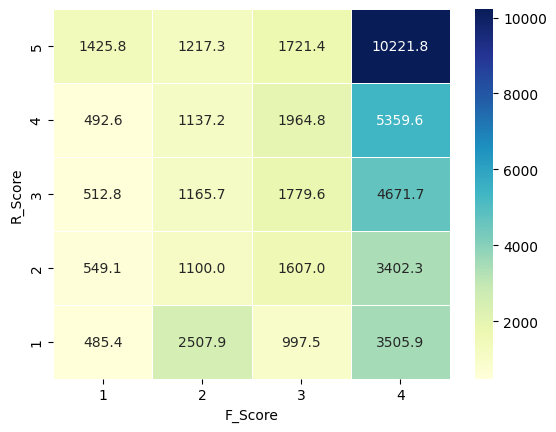

In [49]:
#Визуализация

##Функция для отображения

rfm_heatmap = rfm_df.pivot_table(index='R_Score', columns='F_Score', values='Monetary', aggfunc='mean', observed=False)

##Построение карты

sns.heatmap(rfm_heatmap, cmap="YlGnBu", fmt=".1f", annot=True, linewidths=.5)

In [50]:
#Подготовка к A/B-тесту

##Получение кол-ва клиентов, совершивших вторую покупку (rfm_df содержит только клиентов, совершивших минимум одну оплату)

repeat_buyers = rfm_df[rfm_df['Frequency'] > 1]

##Получение базовой конверсии

p1 = round(len(repeat_buyers) / len(rfm_df), 2)

print('\nБазовая конверсия: ', p1)

##С помощью онлайн-калькулятора получен размер выборки - 2818 суммарно на оба варианта
##Параметры:
##Базовая конверсия = 66%
##Целевая конверсия (прирост) = 5%
##Достоверность = 95%
##Мощность = 80%


Базовая конверсия:  0.66
